## Goal
Understanding the challenges in training neural nets such as :

1. Weight Initialization
2. Adjusting Learning Rates
3. Appropriate use of Normalization
4. Picking the right Activation Functions
5. Understanding the flow of gradients through the network

## Task
Training Autoencoders (AEs) and Variational Autoencoders (VAEs) on the task of efficiently encoding and decoding (reconstructing) images (grayscale) consisting of a white square with side lengthl sampled uniformly and located at some random position in an image that is otherwise of just all black pixels.

(Task inspired from this [paper](https://arxiv.org/pdf/1606.05579) and explained in this [video](https://www.youtube.com/watch?v=9zKuYvjFFS8))

#### Objectives: 
1. Get the autoencoder to learn latent representations that encode the location (x, y) and size of the square to enable 
efficient reconstruction.
2. Observe how well the model is able to perform when the image size is changes or when the number of parameters and the latent size is reduced/increased
3. Identify reasons for exploding gradients if any ([Autoencoders can quickly explode if we are not careful](https://www.reddit.com/r/MachineLearning/comments/56dy7v/how_to_train_an_autoencoder/))

#### Task Modification:
We can consider applying this task with colored squares as well to encourage encoding the color information as well in the latent representation

In [25]:
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

## Creating the dataset

In [26]:
# square_size -> (min_size, max_size)

def generate_datapoint(size = (28, 28), square_size = (3, 7), grayscale = True):
    
    assert square_size[0] < size[0] and square_size[0] < size[1]
    assert square_size[1] < size[0] and square_size[1] < size[1]
    
    random_square_size = random.randint(*square_size)
    
    x_pos = random.randint(0, size[1] - random_square_size)
    y_pos = random.randint(0, size[0] - random_square_size)
    
    if grayscale:
        img = np.zeros(size)
        img[x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = 1.0
    else:
        img = np.zeros((3, *size))
        
        img[0,x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        img[1, x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        img[2, x_pos:x_pos + random_square_size, y_pos:y_pos + random_square_size] = random.random()
        
    
    return img, x_pos, y_pos, random_square_size


def generate_dataset(n = 3000, size = (28, 28), square_size = (3, 7), grayscale = True):
    x = []
    y = []
    
    for _ in range(n):
        img, x_pos, y_pos, spot_size = generate_datapoint(size, square_size, grayscale = grayscale)
        x.append(img)
        y.append([x_pos, y_pos, spot_size])
        
    return np.array(x), np.array(y)

## Define Autoencoder Model

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [28]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    
    def __init__(self,
                 s,
                 data_channels = 1,
                 conv_feature_maps = 16,
                 kernel_size = 3,
                 stride_length = 1,
                 pool_size = 2,
                 fc_size = 256,
                 latent_size = 64
                ):
        super(Autoencoder, self).__init__()
        
        self.is_log_mode = False
        
        conv2d_output_size = (s-kernel_size)//stride_length + 1
        pooling_output_size = conv2d_output_size//2
        deconv2d_output_size = (pooling_output_size - 1) * stride_length + kernel_size
        
        print(f"conv2d_output_size : {conv2d_output_size}")
        print(f"pooling_output_size : {pooling_output_size}")
        print(f"flatten_size : {conv_feature_maps * pooling_output_size * pooling_output_size}")
        
        self.encoder = nn.Sequential(
            nn.Conv2d(data_channels, conv_feature_maps, kernel_size, stride = stride_length),
            nn.BatchNorm2d(conv_feature_maps),  # Add BatchNorm2d after Conv2d
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(pool_size, pool_size),
            
            nn.Flatten(),
            nn.Linear(conv_feature_maps * pooling_output_size * pooling_output_size, fc_size),
            nn.BatchNorm1d(fc_size),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),
            
            nn.Linear(fc_size, latent_size),
            nn.BatchNorm1d(latent_size),  # Add BatchNorm1d after Linear layer
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, fc_size),
            nn.BatchNorm1d(fc_size),  # Add BatchNorm1d after Linear layer
            nn.LeakyReLU(inplace=True),

            nn.Linear(fc_size, conv_feature_maps * pooling_output_size * pooling_output_size),
            nn.LeakyReLU(inplace=True),

            nn.Unflatten(1, (conv_feature_maps, pooling_output_size, pooling_output_size)),  # Match the shape after last Conv2d in encoder
            
            nn.ConvTranspose2d(conv_feature_maps, data_channels, kernel_size, stride = stride_length),
            nn.Upsample(scale_factor= s/deconv2d_output_size, mode='nearest'),
    
            nn.Sigmoid()
        )
                
    def forward(self, x):
    
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded, encoded
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def log_mode(self, val):
        assert type(val) == bool
        self.is_log_mode = val


## Initialize model and data

In [53]:
s = 64
grayscale = True

X, y = generate_dataset(n = 3000, size = (s, s), square_size = (3, 16), grayscale = grayscale)
X_val, y_val = generate_dataset(n = 512, size = (s, s), square_size = (3, 16), grayscale = grayscale)

X.shape, X_val.shape

((3000, 64, 64), (512, 64, 64))

In [54]:
ae_model = Autoencoder(s,
                       data_channels = 1 if grayscale else 3,
                       conv_feature_maps = 8,
                       stride_length = 2,
                       fc_size = 32,
                       latent_size = 16)

conv2d_output_size : 31
pooling_output_size : 15
flatten_size : 1800


In [55]:
ae_model

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1800, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=32, out_features=1800, 

In [56]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-5)

## Train AE (grayscale)

In [57]:
batch_size = 32
n_train_batches = X.shape[0] // batch_size
n_val_batches = X_val.shape[0] // batch_size
n_epochs = 300
losses = []
val_losses = []

for epoch in range(n_epochs):
    
    ae_model.train()
    for batch_ind in range(n_train_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size])
        x = x.unsqueeze(1) if grayscale else x
        reconstructed, _ = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss.item())
    
    ae_model.eval()
    with torch.no_grad():
        val_loss = torch.Tensor([0])
        for batch_ind in range(n_val_batches):
            x = torch.Tensor(X_val[batch_ind * batch_size : (batch_ind + 1) * batch_size])
            x = x.unsqueeze(1) if grayscale else x
            reconstructed, _ = ae_model(x)
            
            val_loss += ae_criterion(reconstructed, x)
            
        
        val_loss = val_loss.item() / n_val_batches
        val_losses.append(val_loss)
        print(f"Epoch : {epoch}/{n_epochs} \t loss = {losses[-1]:.5f} \t val_loss = {val_loss:.5f}")

Epoch : 0/300 	 loss = 0.32269 	 val_loss = 0.32390
Epoch : 1/300 	 loss = 0.32011 	 val_loss = 0.32150
Epoch : 2/300 	 loss = 0.31751 	 val_loss = 0.31912
Epoch : 3/300 	 loss = 0.31492 	 val_loss = 0.31669
Epoch : 4/300 	 loss = 0.31231 	 val_loss = 0.31423
Epoch : 5/300 	 loss = 0.30969 	 val_loss = 0.31171
Epoch : 6/300 	 loss = 0.30703 	 val_loss = 0.30915
Epoch : 7/300 	 loss = 0.30432 	 val_loss = 0.30653
Epoch : 8/300 	 loss = 0.30157 	 val_loss = 0.30385
Epoch : 9/300 	 loss = 0.29877 	 val_loss = 0.30112
Epoch : 10/300 	 loss = 0.29591 	 val_loss = 0.29833
Epoch : 11/300 	 loss = 0.29298 	 val_loss = 0.29546
Epoch : 12/300 	 loss = 0.28998 	 val_loss = 0.29253
Epoch : 13/300 	 loss = 0.28691 	 val_loss = 0.28953
Epoch : 14/300 	 loss = 0.28377 	 val_loss = 0.28647
Epoch : 15/300 	 loss = 0.28055 	 val_loss = 0.28335
Epoch : 16/300 	 loss = 0.27726 	 val_loss = 0.28015
Epoch : 17/300 	 loss = 0.27392 	 val_loss = 0.27688
Epoch : 18/300 	 loss = 0.27051 	 val_loss = 0.27353
Epo

Epoch : 154/300 	 loss = 0.03284 	 val_loss = 0.03159
Epoch : 155/300 	 loss = 0.03261 	 val_loss = 0.03132
Epoch : 156/300 	 loss = 0.03238 	 val_loss = 0.03105
Epoch : 157/300 	 loss = 0.03217 	 val_loss = 0.03078
Epoch : 158/300 	 loss = 0.03196 	 val_loss = 0.03052
Epoch : 159/300 	 loss = 0.03175 	 val_loss = 0.03027
Epoch : 160/300 	 loss = 0.03155 	 val_loss = 0.03002
Epoch : 161/300 	 loss = 0.03135 	 val_loss = 0.02978
Epoch : 162/300 	 loss = 0.03116 	 val_loss = 0.02955
Epoch : 163/300 	 loss = 0.03097 	 val_loss = 0.02932
Epoch : 164/300 	 loss = 0.03078 	 val_loss = 0.02910
Epoch : 165/300 	 loss = 0.03060 	 val_loss = 0.02888
Epoch : 166/300 	 loss = 0.03042 	 val_loss = 0.02867
Epoch : 167/300 	 loss = 0.03025 	 val_loss = 0.02846
Epoch : 168/300 	 loss = 0.03007 	 val_loss = 0.02825
Epoch : 169/300 	 loss = 0.02991 	 val_loss = 0.02806
Epoch : 170/300 	 loss = 0.02974 	 val_loss = 0.02786
Epoch : 171/300 	 loss = 0.02957 	 val_loss = 0.02767
Epoch : 172/300 	 loss = 0.0

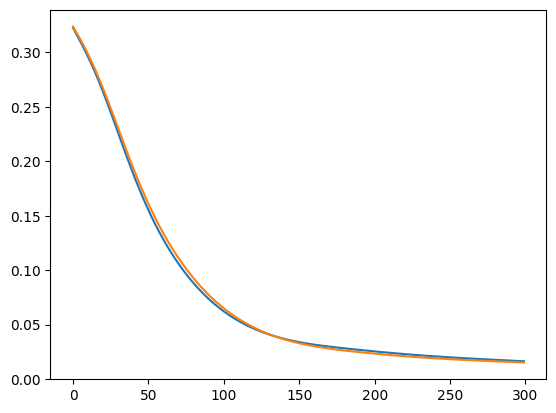

In [58]:
plt.plot(losses)
plt.plot(val_losses)

plt.show()

In [59]:
ae_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1800, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=32, out_features=1800, 

In [60]:
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x

In [61]:
_x.shape

torch.Size([1, 1, 64, 64])

In [62]:
_recon, latent = ae_model(_x)

In [63]:
ae_criterion(_recon, _x)

tensor(0.0289, grad_fn=<MseLossBackward0>)

In [64]:
img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

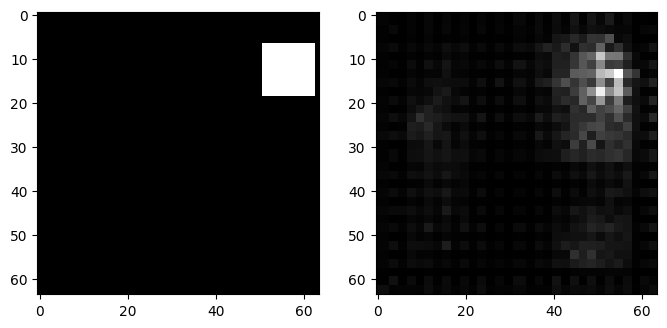

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

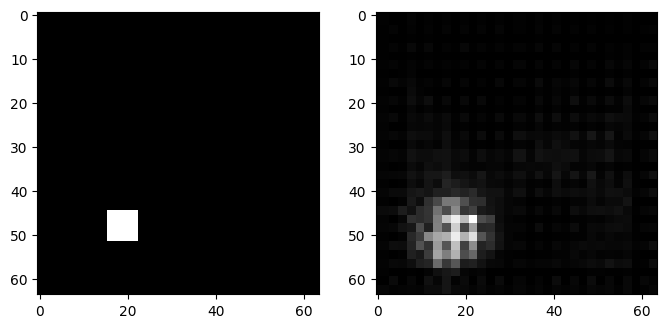

In [66]:
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

## Train AE (RGB)

In [67]:
s = 64
grayscale = False

X, y = generate_dataset(n = 3000, size = (s, s), square_size = (3, 16), grayscale = grayscale)
X_val, y_val = generate_dataset(n = 512, size = (s, s), square_size = (3, 16), grayscale = grayscale)

ae_model = Autoencoder(s,
                       data_channels = 1 if grayscale else 3,
                       conv_feature_maps = 8,
                       stride_length = 2,
                       fc_size = 32,
                       latent_size = 16)

conv2d_output_size : 31
pooling_output_size : 15
flatten_size : 1800


In [68]:
ae_criterion = nn.MSELoss()
ae_optimizer = optim.NAdam(ae_model.parameters(), lr = 1e-5)

In [69]:
batch_size = 32
n_train_batches = X.shape[0] // batch_size
n_val_batches = X_val.shape[0] // batch_size
n_epochs = 500
losses = []
val_losses = []

for epoch in range(n_epochs):
    
    ae_model.train()
    for batch_ind in range(n_train_batches):
        
        x = torch.Tensor(X[batch_ind * batch_size: (batch_ind + 1) * batch_size])
        x = x.unsqueeze(1) if grayscale else x
        reconstructed, _ = ae_model(x)
        loss = ae_criterion(reconstructed, x)

        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
    losses.append(loss.item())
    
    ae_model.eval()
    with torch.no_grad():
        val_loss = torch.Tensor([0])
        for batch_ind in range(n_val_batches):
            x = torch.Tensor(X_val[batch_ind * batch_size : (batch_ind + 1) * batch_size])
            x = x.unsqueeze(1) if grayscale else x
            reconstructed, _ = ae_model(x)
            
            val_loss += ae_criterion(reconstructed, x)
            
        
        val_loss = val_loss.item() / n_val_batches
        val_losses.append(val_loss)
        print(f"Epoch : {epoch}/{n_epochs} \t loss = {losses[-1]:.5f} \t val_loss = {val_loss:.5f}")

Epoch : 0/500 	 loss = 0.25112 	 val_loss = 0.25136
Epoch : 1/500 	 loss = 0.24991 	 val_loss = 0.25025
Epoch : 2/500 	 loss = 0.24872 	 val_loss = 0.24911
Epoch : 3/500 	 loss = 0.24753 	 val_loss = 0.24799
Epoch : 4/500 	 loss = 0.24635 	 val_loss = 0.24686
Epoch : 5/500 	 loss = 0.24513 	 val_loss = 0.24571
Epoch : 6/500 	 loss = 0.24388 	 val_loss = 0.24452
Epoch : 7/500 	 loss = 0.24257 	 val_loss = 0.24329
Epoch : 8/500 	 loss = 0.24122 	 val_loss = 0.24200
Epoch : 9/500 	 loss = 0.23981 	 val_loss = 0.24065
Epoch : 10/500 	 loss = 0.23833 	 val_loss = 0.23924
Epoch : 11/500 	 loss = 0.23677 	 val_loss = 0.23778
Epoch : 12/500 	 loss = 0.23515 	 val_loss = 0.23623
Epoch : 13/500 	 loss = 0.23345 	 val_loss = 0.23462
Epoch : 14/500 	 loss = 0.23167 	 val_loss = 0.23293
Epoch : 15/500 	 loss = 0.22981 	 val_loss = 0.23115
Epoch : 16/500 	 loss = 0.22787 	 val_loss = 0.22931
Epoch : 17/500 	 loss = 0.22583 	 val_loss = 0.22737
Epoch : 18/500 	 loss = 0.22371 	 val_loss = 0.22533
Epo

Epoch : 154/500 	 loss = 0.00975 	 val_loss = 0.01229
Epoch : 155/500 	 loss = 0.00967 	 val_loss = 0.01217
Epoch : 156/500 	 loss = 0.00960 	 val_loss = 0.01206
Epoch : 157/500 	 loss = 0.00953 	 val_loss = 0.01195
Epoch : 158/500 	 loss = 0.00947 	 val_loss = 0.01184
Epoch : 159/500 	 loss = 0.00940 	 val_loss = 0.01174
Epoch : 160/500 	 loss = 0.00934 	 val_loss = 0.01164
Epoch : 161/500 	 loss = 0.00929 	 val_loss = 0.01155
Epoch : 162/500 	 loss = 0.00923 	 val_loss = 0.01145
Epoch : 163/500 	 loss = 0.00918 	 val_loss = 0.01137
Epoch : 164/500 	 loss = 0.00913 	 val_loss = 0.01128
Epoch : 165/500 	 loss = 0.00908 	 val_loss = 0.01120
Epoch : 166/500 	 loss = 0.00903 	 val_loss = 0.01112
Epoch : 167/500 	 loss = 0.00899 	 val_loss = 0.01103
Epoch : 168/500 	 loss = 0.00894 	 val_loss = 0.01096
Epoch : 169/500 	 loss = 0.00890 	 val_loss = 0.01089
Epoch : 170/500 	 loss = 0.00886 	 val_loss = 0.01081
Epoch : 171/500 	 loss = 0.00882 	 val_loss = 0.01075
Epoch : 172/500 	 loss = 0.0

Epoch : 306/500 	 loss = 0.00639 	 val_loss = 0.00732
Epoch : 307/500 	 loss = 0.00637 	 val_loss = 0.00730
Epoch : 308/500 	 loss = 0.00635 	 val_loss = 0.00728
Epoch : 309/500 	 loss = 0.00634 	 val_loss = 0.00726
Epoch : 310/500 	 loss = 0.00632 	 val_loss = 0.00724
Epoch : 311/500 	 loss = 0.00631 	 val_loss = 0.00722
Epoch : 312/500 	 loss = 0.00629 	 val_loss = 0.00720
Epoch : 313/500 	 loss = 0.00627 	 val_loss = 0.00719
Epoch : 314/500 	 loss = 0.00626 	 val_loss = 0.00717
Epoch : 315/500 	 loss = 0.00624 	 val_loss = 0.00715
Epoch : 316/500 	 loss = 0.00623 	 val_loss = 0.00713
Epoch : 317/500 	 loss = 0.00621 	 val_loss = 0.00711
Epoch : 318/500 	 loss = 0.00620 	 val_loss = 0.00710
Epoch : 319/500 	 loss = 0.00618 	 val_loss = 0.00708
Epoch : 320/500 	 loss = 0.00616 	 val_loss = 0.00706
Epoch : 321/500 	 loss = 0.00615 	 val_loss = 0.00705
Epoch : 322/500 	 loss = 0.00613 	 val_loss = 0.00704
Epoch : 323/500 	 loss = 0.00612 	 val_loss = 0.00701
Epoch : 324/500 	 loss = 0.0

Epoch : 458/500 	 loss = 0.00466 	 val_loss = 0.00551
Epoch : 459/500 	 loss = 0.00465 	 val_loss = 0.00550
Epoch : 460/500 	 loss = 0.00464 	 val_loss = 0.00549
Epoch : 461/500 	 loss = 0.00463 	 val_loss = 0.00549
Epoch : 462/500 	 loss = 0.00463 	 val_loss = 0.00548
Epoch : 463/500 	 loss = 0.00462 	 val_loss = 0.00547
Epoch : 464/500 	 loss = 0.00461 	 val_loss = 0.00547
Epoch : 465/500 	 loss = 0.00460 	 val_loss = 0.00546
Epoch : 466/500 	 loss = 0.00460 	 val_loss = 0.00546
Epoch : 467/500 	 loss = 0.00459 	 val_loss = 0.00545
Epoch : 468/500 	 loss = 0.00458 	 val_loss = 0.00544
Epoch : 469/500 	 loss = 0.00458 	 val_loss = 0.00544
Epoch : 470/500 	 loss = 0.00457 	 val_loss = 0.00543
Epoch : 471/500 	 loss = 0.00456 	 val_loss = 0.00543
Epoch : 472/500 	 loss = 0.00455 	 val_loss = 0.00542
Epoch : 473/500 	 loss = 0.00455 	 val_loss = 0.00542
Epoch : 474/500 	 loss = 0.00454 	 val_loss = 0.00541
Epoch : 475/500 	 loss = 0.00453 	 val_loss = 0.00540
Epoch : 476/500 	 loss = 0.0

In [70]:
ae_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1800, out_features=32, bias=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Linear(in_features=32, out_features=1800, 

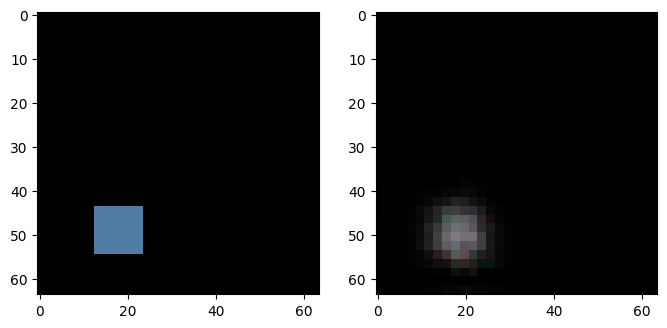

In [71]:
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

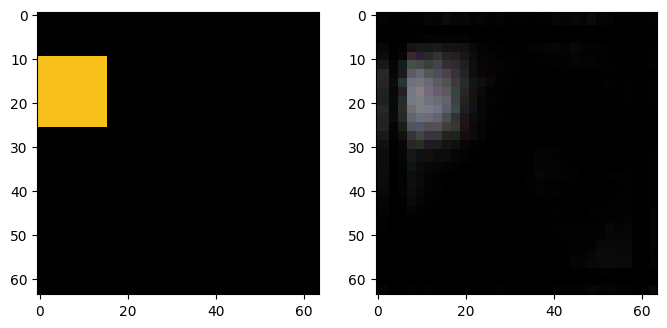

In [72]:
_x = torch.Tensor(X_val[random.randint(0, X_val.shape[0])]).unsqueeze(0)
_x = _x.unsqueeze(1) if grayscale else _x
_recon, latent = ae_model(_x)

img = np.array(_x.squeeze().detach().numpy())
recon_img = _recon.squeeze().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(img.T, cmap = 'gray' if grayscale else None)
axes[1].imshow(recon_img.T, cmap = 'gray' if grayscale else None)

plt.show()

## Scratch Area

In [153]:
torch.Tensor(X[32:64]).unsqueeze(1).shape

torch.Size([32, 1, 32, 32])

In [198]:
ae_criterion(torch.Tensor(X[0:batch_size]).unsqueeze(1).flatten(), torch.Tensor(X[batch_size:batch_size*2]).unsqueeze(1).flatten())

0.0465235710144043

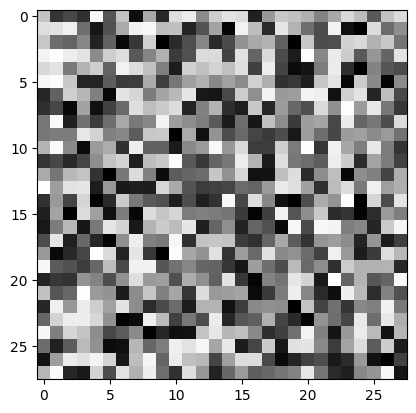

In [85]:
# x = np.ones((28, 28), dtype = np.uint8) * 255
# plt.imshow(x, cmap='gray', vmin=0, vmax=255)


x = np.ones((28, 28)) * np.random.uniform(size = (28, 28)) * 255
plt.imshow(x, cmap = 'gray')